# Reduce images of CTIO Data in January 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : January 24th 2017

### This notebook does reduction of images from Master Bias and Master Dark.
-----------------------------------------

- the images should have been previously Overscanned and Trimmed
- Notice the images are saved in images_notebooks/notebook_name
- must execute the javascript below first

In [3]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [4]:
print theNotebook

ReduceAllImages_HD14943


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [6]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [7]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [8]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [9]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [10]:
from IPython.display import Image, display

In [11]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [12]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [13]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

### Output directory for images generated in the notebook view (not true fits images)

In [14]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [15]:
ensure_dir(dir_top_images) # create that directory

### Output of reduced fits images

In [16]:
outputdir="reduced_fitsimages"
ensure_dir(outputdir)

## Bias and Flat

In [17]:
inputbiasfile="MasterBias_CTIO_20170118.fits"

In [18]:
inputflatfile="MasterFlat_CTIO_20170118.fits"

In [19]:
master_bias = ccdproc.CCDData.read(inputbiasfile,unit=u.adu)

In [20]:
master_flat = ccdproc.CCDData.read(inputflatfile,unit=u.adu)

In [21]:
imstats = lambda dat: (dat.min(), dat.max(), dat.mean(), dat.std())

## Location of corrected images
----------------------------------

In [22]:
rootpath_rawimage="./trim_images"
object_name='HD14943'

In [23]:
#dirlist_all=os.listdir(rootpath_rawimage) 

In [24]:
#if '.DS_Store' in dirlist_all:
#    dirlist_all.remove('.DS_Store')
dirlist=[]
dirlist.append(rootpath_rawimage)
dirlist_all=np.array(dirlist)

In [25]:
print dirlist_all

['./trim_images']


In [26]:
!ls trim_images

trim_20170118_247.fits trim_20170118_251.fits
trim_20170118_249.fits trim_20170118_253.fits


In [27]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [28]:
def MakeFileList():
    """
    MakeFileList : Make The List of files to open
    =============
    """
    count=0
    
    for dir in dirlist_all: # loop on directories, one per image       
            dir_leaf= dir # build the name of leaf directory
            listfiles=os.listdir(dir_leaf) 
            for filename in listfiles:
                if re.search('^trim_20170118_([0-9]+).fits$',filename):  #example of filename filter
                    str_index=re.findall('^trim_20170118_([0-9]+).fits$',filename)
                    count=count+1
                    index=int(str_index[0])
                    indexes_files.append(index)         
                    shortfilename=dir_leaf+'/'+filename
                    filelist_fitsimages.append(shortfilename)
                    
    return

In [29]:
MakeFileList()   # Make the list

In [30]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [31]:
print len(indexes_files)

4


In [32]:
print len(filelist_fitsimages)

4


In [33]:
print indexes_files

[247 249 251 253]


In [34]:
len(indexes_files)

4

In [35]:
filelist_fitsimages

array(['./trim_images/trim_20170118_247.fits',
       './trim_images/trim_20170118_249.fits',
       './trim_images/trim_20170118_251.fits',
       './trim_images/trim_20170118_253.fits'], 
      dtype='|S36')

In [36]:
len(filelist_fitsimages)

4

In [37]:
#sorted_dates=np.argsort(filelist_fitsimages)

In [38]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [39]:
sorted_indexes

array([0, 1, 2, 3])

In [40]:
#print sorted_dates

In [41]:
print sorted_indexes

[0 1 2 3]


In [42]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [43]:
#sorted_numbers= [indexes_files[index] for index in sorted_indexes]
sorted_numbers=indexes_files[sorted_indexes]

In [44]:
sorted_numbers

array([247, 249, 251, 253])

In [45]:
sorted_files

array(['./trim_images/trim_20170118_247.fits',
       './trim_images/trim_20170118_249.fits',
       './trim_images/trim_20170118_251.fits',
       './trim_images/trim_20170118_253.fits'], 
      dtype='|S36')

## Build full filename
----------------------------

In [46]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(rootpath_rawimage,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [47]:
sorted_filenames=np.array(sorted_filenames)

In [48]:
sorted_filenames

array(['./trim_images/trim_20170118_247.fits',
       './trim_images/trim_20170118_249.fits',
       './trim_images/trim_20170118_251.fits',
       './trim_images/trim_20170118_253.fits'], 
      dtype='|S36')

## Acces to data of  images
----------------------------------

In [49]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []

In [50]:
def BuildRawImages():
    """
    BuildRawImages
    ===============
    """

    global all_dates
    global all_airmass
    global all_images
    global all_titles
    global all_header
    global all_img 
    global sorted_filenames

    for idx,file in np.ndenumerate(sorted_filenames):   
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        num=sorted_numbers[idx[0]]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        hdu_list.close()

In [51]:
BuildRawImages()

## Show images
-----------------------

In [52]:
def ShowRawImages():
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    global all_images
    global all_titles
    global object_name

    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/4)+1

    f, axarr = plt.subplots(MAXIMGROW,4,figsize=(20,10))
    for index in np.arange(0,NBIMAGES):
        ix=index%4
        iy=index/4
        im=axarr[iy,ix].imshow(all_images[index],vmin=-10,vmax=100)
        axarr[iy,ix].set_title(all_titles[index])
    title='Raw images of '.format(object_name)
    plt.suptitle(title,size=16)  
    figfilename=os.path.join(dir_top_images,'viewrawimages.pdf')
    plt.savefig(figfilename)                             

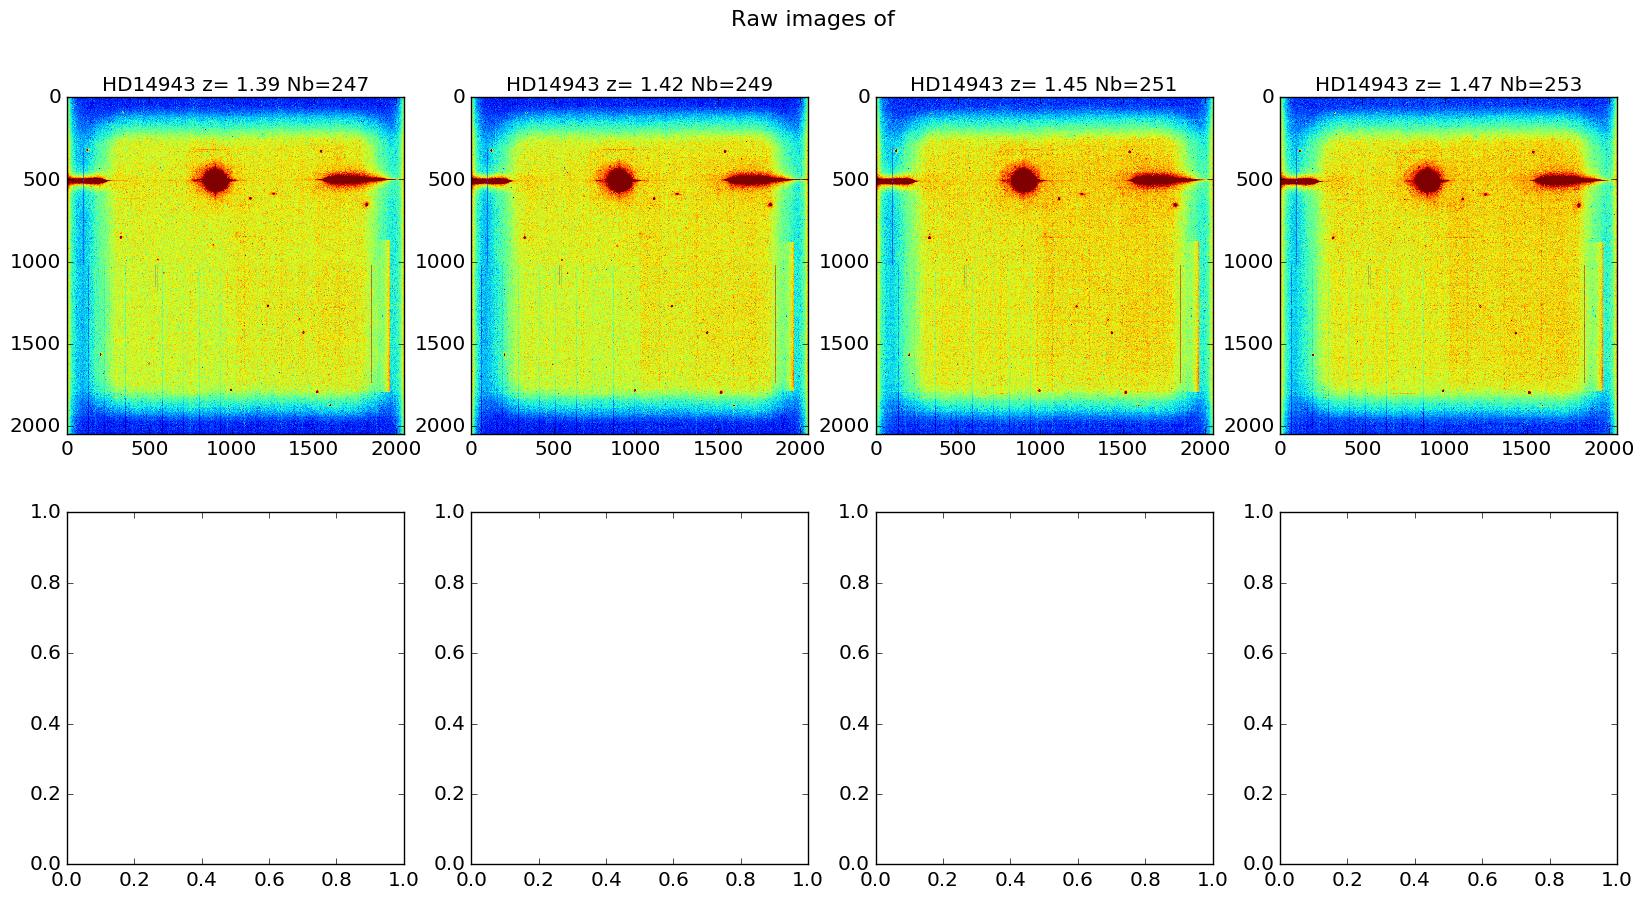

In [53]:
ShowRawImages()

In [54]:
#(y0,x0)=np.where(data2==data2.max())

## Show histograms
===========================

In [55]:
def ShowHistograms():
    """
    ShowHistograms
    ==============
    """
    global all_images
    global all_titles
    global object_name


    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/4)+1
    
    f, axarr = plt.subplots(MAXIMGROW,4,figsize=(20,10))
    for index in np.arange(0,NBIMAGES):
        ix=index%4
        iy=index/4
        image_flat=all_images[index].flatten()
        stat_mean=image_flat.mean()
        stat_rms=image_flat.std()
        legtitle='mean={:4.2f} std={:4.2f}'.format(stat_mean,stat_rms)
        axarr[iy,ix].hist(image_flat,bins=100,range=(-50,200),facecolor='blue', alpha=0.75,label=legtitle);
        axarr[iy,ix].set_yscale('log')
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,1e10)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].legend(loc='best')  #useless
    title='histo of images '.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,'histosrawimages.pdf')
    plt.savefig(figfilename)    

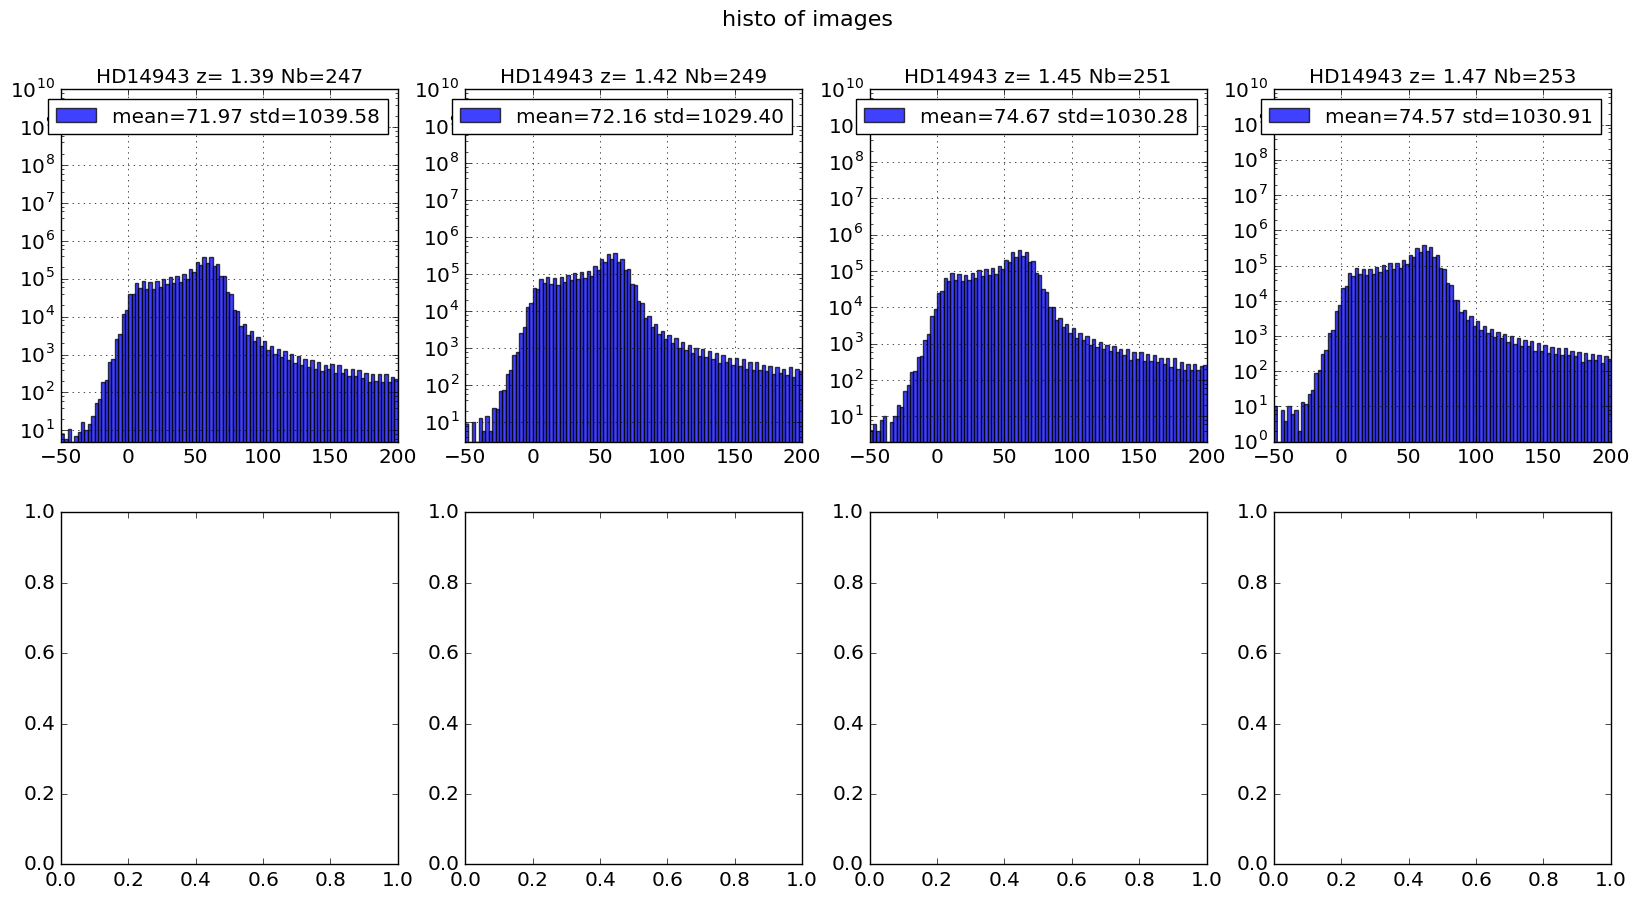

In [56]:
ShowHistograms()

## Transfer the image in CCDData
====================================

In [57]:
NBIMAGES=len(all_images)
all_rawimage = []
for index in np.arange(0,NBIMAGES):
    rawccd=ccdproc.CCDData(all_images[index],unit='adu')
    all_rawimage.append(rawccd)

## Does the reduction
===========================

### Step 1 : Subtract Bias to each raw image

In [58]:
all_bias_subtracted = []
for raw_image in all_rawimage:
    bias_subtracted = ccdproc.subtract_bias(raw_image, master_bias)
    all_bias_subtracted.append(bias_subtracted)

### Step 2 : Normalize by Flat

In [59]:
all_reduced = []
for bias_sub in all_bias_subtracted:
    reduced_image = ccdproc.flat_correct(bias_sub, master_flat,min_value=0.9)
    all_reduced.append(reduced_image)

## Plot Reduced Image
=========================

In [60]:
def PlotReduced():
    """
    PlotReduced
    ===============
    """
    
    global all_reduced
    global all_title
    global object_name
    
    NBBKG=len(all_reduced)
    MAXIMGROW=int(NBBKG/4)+1
      
    
    f, axarr = plt.subplots(MAXIMGROW,4,figsize=(20,10))
    for index in np.arange(0,NBBKG):
        ix=index%4
        iy=index/4
        im=axarr[iy,ix].imshow(all_reduced[index],vmin=0,vmax=100)
        axarr[iy,ix].set_title(all_titles[index])
    title='Reduced image {}'.format(object_name)

    #f.colorbar(im, ax=axarr.ravel().tolist(),shrink=0.75)
    f.colorbar(im)
    plt.suptitle(title,size=16) 
    figfilename=os.path.join(dir_top_images,'redimages.pdf')
    plt.savefig(figfilename)    

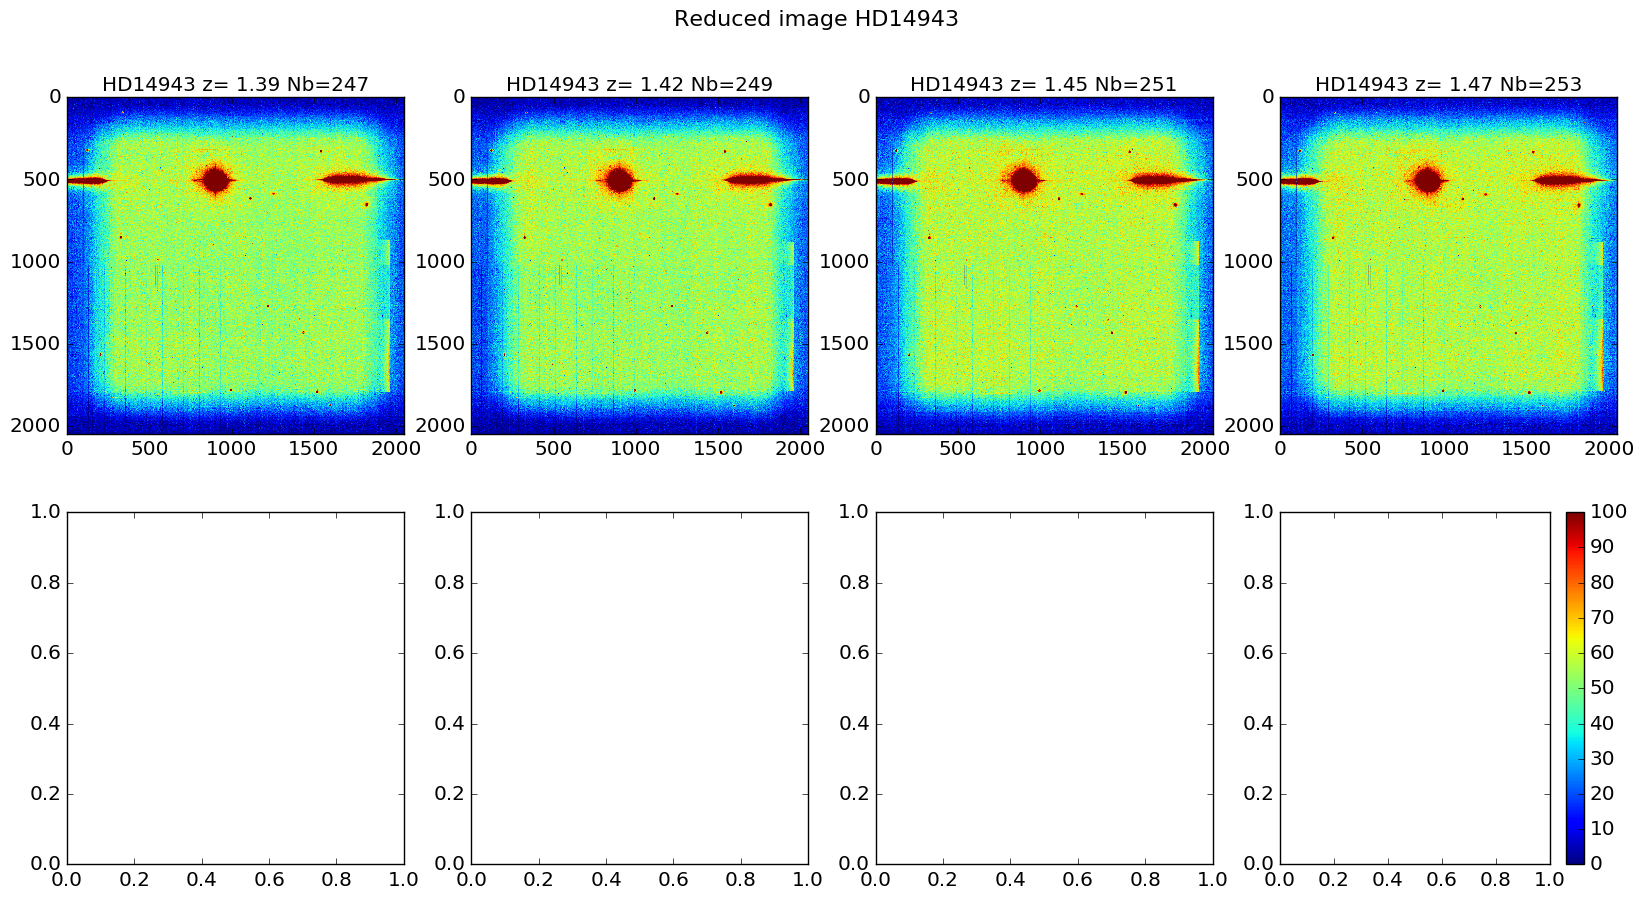

In [61]:
PlotReduced()

In [62]:
def PlotHistoReduced():
    """
    """
    
    global all_reduced
    global all_title
    global object_name
    
    NBIMG=len(all_reduced)
    MAXIMGROW=int(NBIMG/4)+1
    
    f, axarr = plt.subplots(MAXIMGROW,4,figsize=(20,10))
    for index in np.arange(0,NBIMG):
        ix=index%4
        iy=index/4
        image_flat=all_reduced[index].data.flatten()
        stat_mean=image_flat.mean()
        stat_rms=image_flat.std()
        legtitle='mean={:4.2f} std={:4.2f}'.format(stat_mean,stat_rms)
        axarr[iy,ix].hist(image_flat,bins=120,range=(-50,200),facecolor='blue', alpha=0.75,label=legtitle);
        axarr[iy,ix].set_yscale('log')
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,1e10)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].legend(loc='best')  #useless
    title='histo of reduced images of {}'.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,'historedimages.pdf')
    plt.savefig(figfilename) 

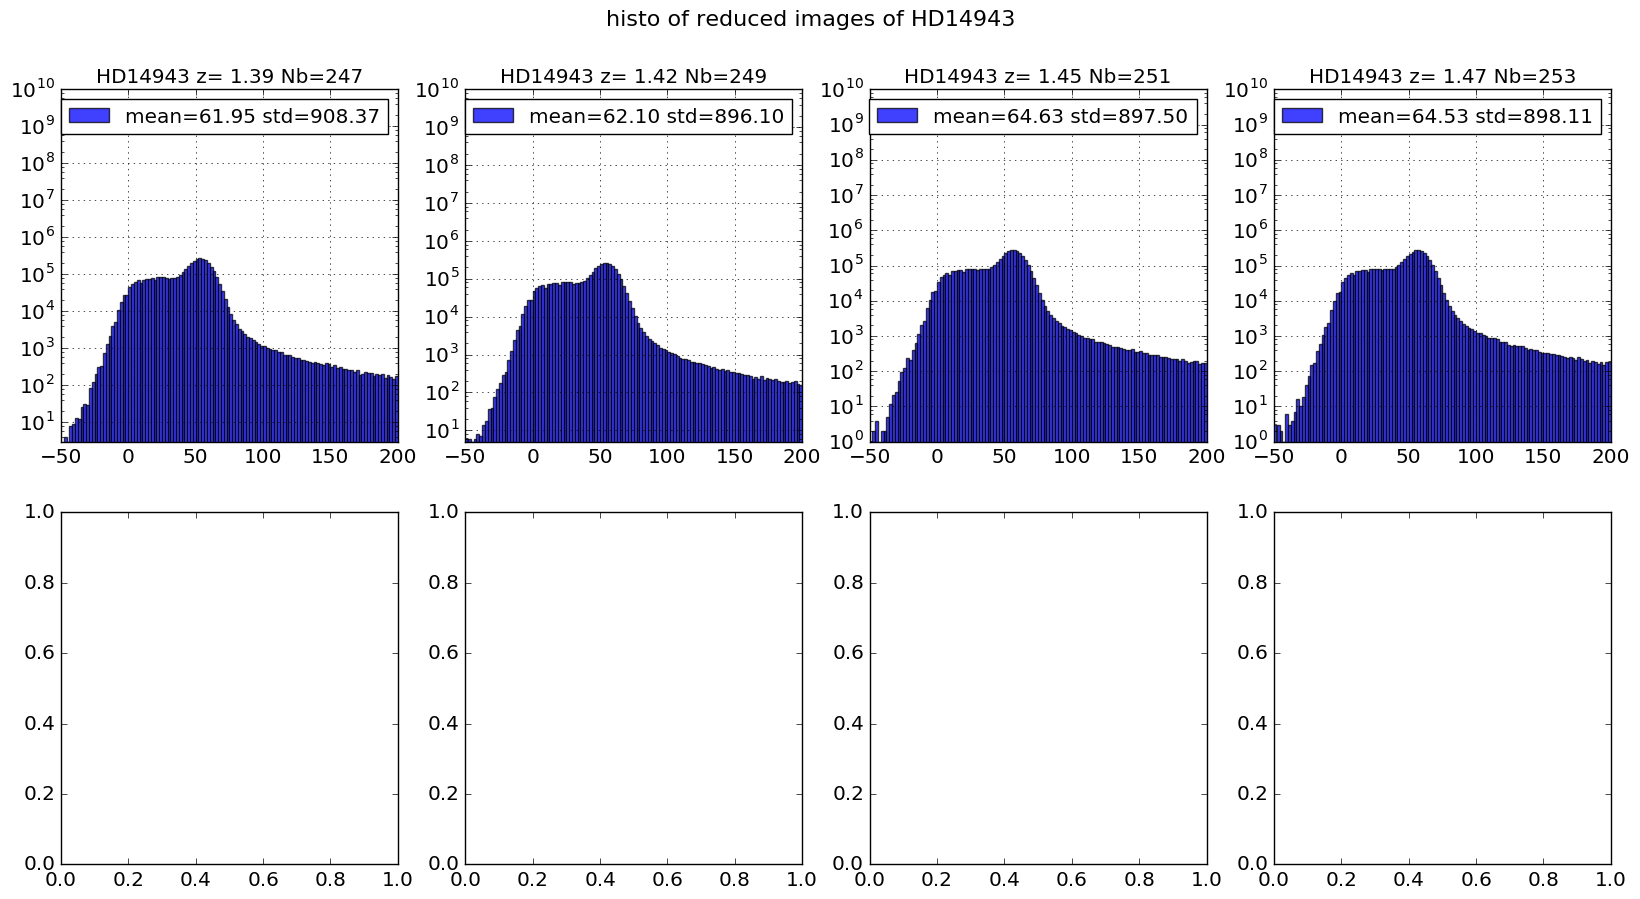

In [63]:
PlotHistoReduced()

## Save the files with background subtraction
----------------------------------------------------------

In [64]:
sorted_newfiles=[]
for idx,file in np.ndenumerate(sorted_files):
    extracted=re.findall('./trim_images/trim_(.+)', file)
    rootfilename=extracted[0]
    newfilename='reduced_'+object_name+'_'+rootfilename
    newfullfilename=os.path.join(outputdir,newfilename)
    sorted_newfiles.append(newfullfilename)

In [65]:
for idx,file in np.ndenumerate(sorted_newfiles):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=all_reduced[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,clobber=True)

In [66]:
sorted_newfiles

['reduced_fitsimages/reduced_HD14943_20170118_247.fits',
 'reduced_fitsimages/reduced_HD14943_20170118_249.fits',
 'reduced_fitsimages/reduced_HD14943_20170118_251.fits',
 'reduced_fitsimages/reduced_HD14943_20170118_253.fits']